In [ ]:
####Passos iniciais
##Instalar o java -> criar variáveis de ambiente ex:
#import os
# os.environ["JAVA_HOME"] = "endereço onde o java foi instalado"
# os.environ["SPARK_HOME"] = "endereço onde o Spark foi instalado"
##Para instalar o framework
#%pip install pyspark

In [1]:
#Versão da linguagem Python
from platform import python_version
print("versão da linguagem python usada neste Jupyter Notbook", python_version())

versão da linguagem python usada neste Jupyter Notbook 3.11.9


# Preparativos

In [2]:
#Importar a findspark
import findspark

In [3]:
#Inicializar findspark
findspark.init()

In [4]:
#Importar SparkSession
from pyspark.sql import SparkSession as Ss

In [5]:
# Construir Session
spark = Ss.builder\
    .master("local")\
    .appName("CarrosClustering")\
    .getOrCreate()
#A SparkSession gerencia o SparkContext internamente não sendo necessário criar um SparkContext separadamente.
#master("local") - para facilitar depuração e a análise de resultados (O Spark será executado em um único nó).

In [6]:
# Definir o nível de log durante a execução:
spark.sparkContext.setLogLevel("ERROR")
#A melhor prática é definir o nível de log usando a configuração spark.log.level no arquivo spark-defaults.conf
# ou através do comando spark-submit.
# Isso garante que o nível de log seja aplicado a todo o aplicativo Spark.

# Carregar os dados

In [7]:
carrosDF = spark.read.csv("dados/dataset.csv", header=True, inferSchema=True, sep=";")
#header = True, pois o arquivo possui cabeçalho
#inferSchema - será inferido os tipos de dados em cada coluna

In [8]:
#Visualizar a Estrutura do DataFrame
carrosDF.printSchema()

root
 |-- fabricante: string (nullable = true)
 |-- tipo_combustivel: string (nullable = true)
 |-- aspirado: string (nullable = true)
 |-- portas: string (nullable = true)
 |-- tipo: string (nullable = true)
 |-- direcao: string (nullable = true)
 |-- cilindros: string (nullable = true)
 |-- horsepower: integer (nullable = true)
 |-- rpm: integer (nullable = true)
 |-- consumo_cidade: integer (nullable = true)
 |-- consumo_estrada: integer (nullable = true)
 |-- preco: integer (nullable = true)



- fabricante; tipo_combustivel; aspirado; portas; tipo; direcao; e  cilindros - São Strings
- horsepower; rpm; consumo_cidade; consumo_estrada; e preco                   - São Integers.

In [9]:
#Visualizar tabela
carrosDF.show(5)

+----------+----------------+--------+------+---------+-------+---------+----------+----+--------------+---------------+-----+
|fabricante|tipo_combustivel|aspirado|portas|     tipo|direcao|cilindros|horsepower| rpm|consumo_cidade|consumo_estrada|preco|
+----------+----------------+--------+------+---------+-------+---------+----------+----+--------------+---------------+-----+
|    subaru|             gas|     std|   two|hatchback|    fwd|     four|        69|4900|            31|             36| 5118|
| chevrolet|             gas|     std|   two|hatchback|    fwd|    three|        48|5100|            47|             53| 5151|
|     mazda|             gas|     std|   two|hatchback|    fwd|     four|        68|5000|            30|             31| 5195|
|    toyota|             gas|     std|   two|hatchback|    fwd|     four|        62|4800|            35|             39| 5348|
|mitsubishi|             gas|     std|   two|hatchback|    fwd|     four|        68|5500|            37|       

In [10]:
#Importar funções para analise dos dados
from pyspark.sql.functions import count, col, asc, desc, when

In [11]:
#Quantos carros por Fabricantes 
fabCount = carrosDF.groupBy("fabricante").count().orderBy(col("count").desc())
fabCount.show()

+-------------+-----+
|   fabricante|count|
+-------------+-----+
|       toyota|   32|
|       nissan|   18|
|        mazda|   16|
|   mitsubishi|   13|
|        honda|   13|
|   volkswagen|   12|
|       subaru|   12|
|       peugot|   11|
|        volvo|   11|
|          bmw|    8|
|        dodge|    8|
|mercedes-benz|    8|
|     plymouth|    7|
|         saab|    6|
|         audi|    6|
|      porsche|    4|
|       jaguar|    3|
|  alfa-romero|    3|
|    chevrolet|    3|
|        isuzu|    2|
+-------------+-----+
only showing top 20 rows



In [12]:
# Selecionar Colunas Numéricas
col_N = [col for col, dtype in carrosDF.dtypes if dtype in ('int', 'double','float')]
col_N_carros = carrosDF.select(col_N)

In [13]:
#Gerar Estatística Descritivas e Converter para Pandas
descricao = col_N_carros.describe().toPandas()
descricao

,summary,horsepower,rpm,consumo_cidade,consumo_estrada,preco
0,count,197,197,197,197,197
1,mean,103.60406091370558,5118.0203045685275,25.15228426395939,30.629441624365484,13279.644670050762
2,stddev,37.63920534951834,481.03591405011434,6.437862917085909,6.836258837310617,8010.334218462034
3,min,48,4150,13,16,5118
4,max,262,6600,49,54,45400


# Pré-processamento dos dados

In [ ]:
#Iremos usar para o modelo
##Portas            - Categórico
##Tipo              - Categórico
##Horsepower        - Numérico
##Rpm               - Numérico
##Concumo_cidade    - Numérico

In [14]:
#Criando novo DF com apenas as colunas desejadas
novoCarrosDF = carrosDF.select("portas","tipo","horsepower","rpm","consumo_cidade")
novoCarrosDF.show(5)

+------+---------+----------+----+--------------+
|portas|     tipo|horsepower| rpm|consumo_cidade|
+------+---------+----------+----+--------------+
|   two|hatchback|        69|4900|            31|
|   two|hatchback|        48|5100|            47|
|   two|hatchback|        68|5000|            30|
|   two|hatchback|        62|4800|            35|
|   two|hatchback|        68|5500|            37|
+------+---------+----------+----+--------------+
only showing top 5 rows



In [15]:
#Transformando as colunas numéricas em float
colunas2=["horsepower", "rpm","consumo_cidade"]
CarrosDF2 = novoCarrosDF
for col in colunas2:
    CarrosDF2 = CarrosDF2.withColumn(col+"f",CarrosDF2[col].cast("float")).drop(col)

CarrosDF2.show()

+------+---------+-----------+------+---------------+
|portas|     tipo|horsepowerf|  rpmf|consumo_cidadef|
+------+---------+-----------+------+---------------+
|   two|hatchback|       69.0|4900.0|           31.0|
|   two|hatchback|       48.0|5100.0|           47.0|
|   two|hatchback|       68.0|5000.0|           30.0|
|   two|hatchback|       62.0|4800.0|           35.0|
|   two|hatchback|       68.0|5500.0|           37.0|
|   two|hatchback|       60.0|5500.0|           38.0|
|   two|    sedan|       69.0|5200.0|           31.0|
|   two|hatchback|       68.0|5500.0|           37.0|
|   two|hatchback|       68.0|5500.0|           37.0|
|   two|hatchback|       68.0|5000.0|           31.0|
|   two|hatchback|       68.0|5500.0|           31.0|
|  four|hatchback|       68.0|5500.0|           31.0|
|  four|hatchback|       68.0|5500.0|           31.0|
|   two|hatchback|       70.0|5400.0|           38.0|
|   two|hatchback|       62.0|4800.0|           31.0|
|   two|hatchback|       68.

In [16]:
#Identificar Valores únicos em portas
portasDf = novoCarrosDF.groupBy("portas").count().toPandas()
portasDf.head()

,portas,count
0,two,85
1,four,112


In [17]:
#Identificar Valores únicos em tipo
tipoDf = novoCarrosDF.groupBy("tipo").count().toPandas()
tipoDf.head()

,tipo,count
0,wagon,24
1,convertible,6
2,sedan,92
3,hatchback,67
4,hardtop,8


------

In [18]:
#portas = [item for item in portasDf["portas"]]
#tipos = [tipo for tipo in tipoDf["tipo"]]# Realidade
portas=["two"]
tipos= ["sedan"]
#print(portas)
#print(tipos)

In [19]:
#Tranformando dados categóricos em númericos
def transform (coluna,Df,List):

    for item in List:
        i = List.index(item) + 1
        Df = Df.withColumn(coluna, when(Df[coluna] == item, float(i) ).otherwise(2.0))
        
    return Df

In [20]:
#Percorrer entre colunas e listas de valores unicos
Colunas = ["portas","tipo"]
Listas = [portas,tipos]
for i in range(0,len(Colunas)):
    CarrosDF2 = transform(Colunas[i],CarrosDF2,Listas[i])

CarrosDF2.show(n=3)

+------+----+-----------+------+---------------+
|portas|tipo|horsepowerf|  rpmf|consumo_cidadef|
+------+----+-----------+------+---------------+
|   1.0| 2.0|       69.0|4900.0|           31.0|
|   1.0| 2.0|       48.0|5100.0|           47.0|
|   1.0| 2.0|       68.0|5000.0|           30.0|
+------+----+-----------+------+---------------+
only showing top 3 rows



In [21]:
#Gerar Estatística Descritivas e Converter para Pandas
descricaoNova = CarrosDF2.describe().toPandas()
descricaoNova

,summary,portas,tipo,horsepowerf,rpmf,consumo_cidadef
0,count,197,197,197,197,197
1,mean,1.5685279187817258,1.532994923857868,103.60406091370558,5118.0203045685275,25.15228426395939
2,stddev,0.49654352778167493,0.5001812579359883,37.63920534951834,481.03591405011434,6.437862917085909
3,min,1.0,1.0,48.0,4150.0,13.0
4,max,2.0,2.0,262.0,6600.0,49.0


In [22]:
#Extraindo a média e o desvio padrão
medias = descricaoNova.iloc[1,1:6].values.tolist()
desvios = descricaoNova.iloc[2,1:6].values.tolist()

# Sumarizando os dados

In [23]:
# Acesse o SparkContext a partir da sessão Spark
sc = spark.sparkContext

In [24]:
# Colocando a média e o desvio padrão disponível em todo cluster
bc_media = sc.broadcast(medias)
bc_desvio = sc.broadcast(desvios)

In [25]:
#Importar módulo para criar vetores densos e esparsos
from pyspark.ml.linalg import Vectors

In [26]:
#Importando classe Row para criar objetos de linha - Linhas com campos nomeados
from pyspark.sql import Row

In [27]:
#Função para Normalizar os valores de Entrada e criar os vetores densos
def centerAndScale(inRow):
  #Variáveis Globais
  global bc_media
  global bc_desvio
  #Array de médias e desvios
  meanArray = bc_media.value
  stdArray = bc_desvio.value
  #Array para o resultados
  retArray= []
  #Loop para calculo
  for i in range(len(meanArray)):
    retArray.append((float(inRow[i])-float(meanArray[i]))/float(stdArray[i]))
  return Row(features = Vectors.dense(retArray)) #Retorna um campo com os vetores densos

# Criando Estrutura de dados distribuida

In [28]:
#Criando um RDD
carrosRDD = CarrosDF2.rdd.map(centerAndScale)

In [29]:
#Criar novo DataFrame
carrosDfNormalizado = spark.createDataFrame(carrosRDD)
carrosDfNormalizado.select("features").show(15)

+--------------------+
|            features|
+--------------------+
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
|[0.86895117361793...|
|[0.86895117361793...|
|[-1.1449709581789...|
|[-1.1449709581789...|
+--------------------+
only showing top 15 rows



# Clusterização

In [30]:
#Importando classe KMeans para clusterização K-means
from pyspark.ml.clustering import KMeans

In [31]:
#Importando a classe ClusteringEvaluator para avaliar a qualidade dos clusters
from pyspark.ml.evaluation import ClusteringEvaluator

In [32]:
#Avaliar Clustering
avaliador = ClusteringEvaluator()

In [33]:
#Testar numeros diferentes de clusters
#Será usado o método Silhueta que mede a coesão e a separação dos clusters
#Objetivo: Encontrar k que Máximize a pontuação da silhueta
resultados = {}
for k in range(2,6):
    kmeans = KMeans(k=k,seed=1)
    model = kmeans.fit(carrosDfNormalizado)
    predictions = model.transform(carrosDfNormalizado)
    silhouette = avaliador.evaluate(predictions)
    resultados[k]=silhouette


In [34]:
#Resultado
print(f"Para k={max(resultados,key=resultados.get)}, silhueta é {resultados[max(resultados,key=resultados.get)]}")

Para k=2, silhueta é 0.429177856807308


In [35]:
#Criando o modelo
kmeans = KMeans(k=3, seed=1)

In [36]:
#Treina o modelo
modelo = kmeans.fit(carrosDfNormalizado)

In [37]:
#Previsões
previsoes = modelo.transform(carrosDfNormalizado)
previsoes.show()

+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|[-1.1449709581789...|         0|
|[-1.1449709581789...|         0|
|[-1.1449709581789...|         0|
|[-1.1449709581789...|         0|
|[-1.1449709581789...|         0|
|[-1.1449709581789...|         0|
|[-1.1449709581789...|         0|
|[-1.1449709581789...|         0|
|[-1.1449709581789...|         0|
|[-1.1449709581789...|         0|
|[-1.1449709581789...|         0|
|[0.86895117361793...|         0|
|[0.86895117361793...|         0|
|[-1.1449709581789...|         0|
|[-1.1449709581789...|         0|
|[-1.1449709581789...|         0|
|[-1.1449709581789...|         0|
|[0.86895117361793...|         0|
|[-1.1449709581789...|         0|
|[0.86895117361793...|         0|
+--------------------+----------+
only showing top 20 rows



In [38]:
#Importar a biblioteca pandas
import pandas as pd

In [39]:
#Extrair as 5 caracteristicas das previsões (portas...)
def unstripData(instr):
  return (instr["prediction"],
          instr["features"][0],
          instr["features"][1],
          instr["features"][2],
          instr["features"][3],
          instr["features"][4],)

In [40]:
#Aplicar a função nas previsões
carrosRDD2 = previsoes.rdd.map(unstripData)
predList = carrosRDD2.collect()

In [41]:
#Converter em DataFrame
predPd = pd.DataFrame(predList)
predPd.head(20)

,0,1,2,3,4,5
0,0,-1.144971,0.933672,-0.919362,-0.453231,0.908332
1,0,-1.144971,0.933672,-1.477291,-0.037461,3.393629
2,0,-1.144971,0.933672,-0.945930,-0.245346,0.753001
3,0,-1.144971,0.933672,-1.105338,-0.661116,1.529656
4,0,-1.144971,0.933672,-0.945930,0.794077,1.840318
5,0,-1.144971,0.933672,-1.158475,0.794077,1.995649
6,0,-1.144971,-1.065604,-0.919362,0.170423,0.908332
7,0,-1.144971,0.933672,-0.945930,0.794077,1.840318
8,0,-1.144971,0.933672,-0.945930,0.794077,1.840318
9,0,-1.144971,0.933672,-0.945930,-0.245346,0.908332


# Visualização (utilizando o Pandas)

In [42]:
#Importando o módulo matplotlib.pylab para criação de gráficos
import matplotlib.pylab as plt

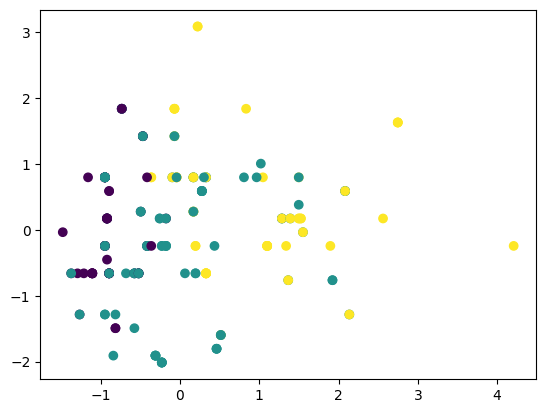

In [43]:
#Resultado das cluscters criadas
plt.cla()
plt.scatter(predPd[3],predPd[4],c=predPd[0])

FIM